In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../common')

In [6]:
import os
import matplotlib.pyplot as plt
import pandas
import numpy as np

#import collect_dem
#import mesh_fncs
import inverse_tools

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['text.latex.preamble'] = '\\usepackage{amsmath}'

In [13]:
zoom = 5
proj = 'utm48R'
n_dem_interp_pts = 300

In [32]:
m_refined_wenchuan = np.load('refined_mesh.npy').tolist()
inverse_soln = np.load('0.0007_xyz_inverse_soln.npy')
chunk_bounds, m_refined, strike_slip = np.load('lander_panels_data.npy')

48R
48R
48R
48R


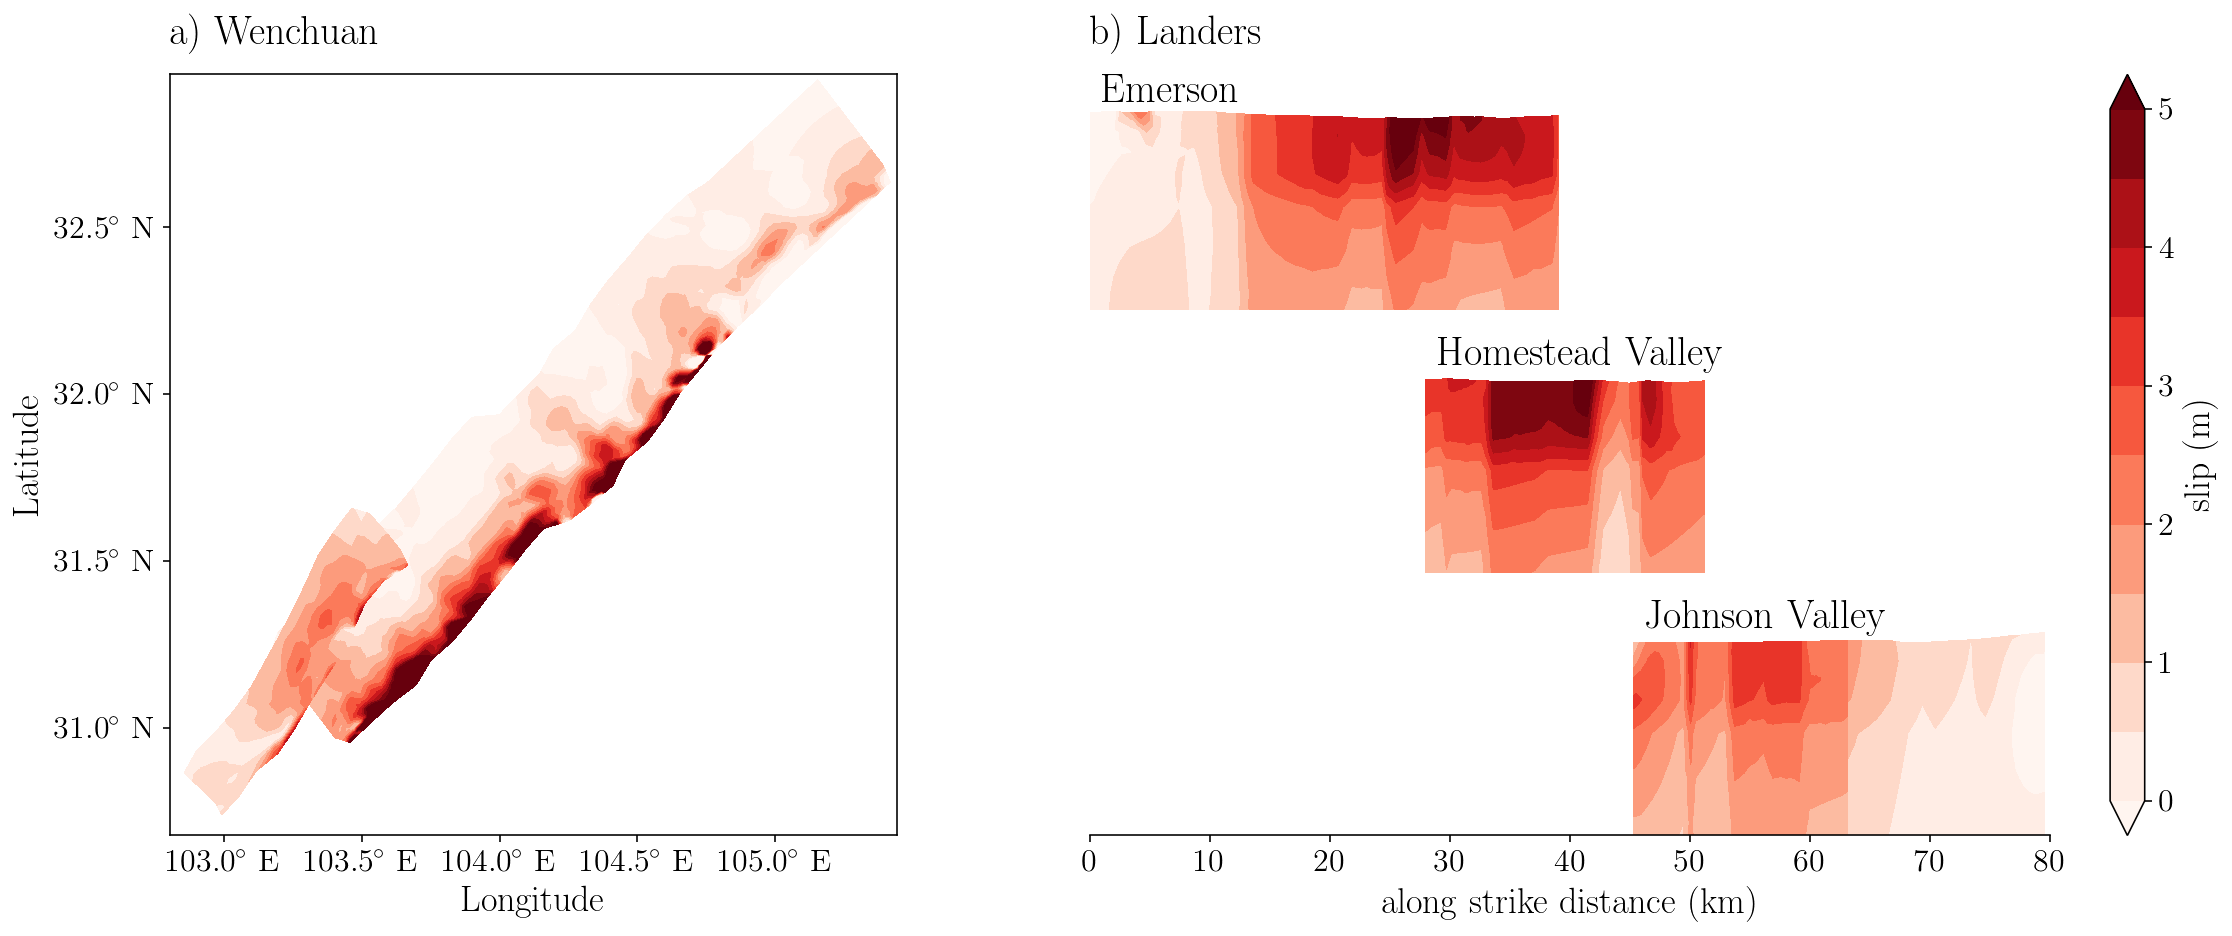

In [67]:
comp = 1
vert_vals = inverse_tools.get_vert_vals_linear(
    (m_refined_wenchuan.pts, m_refined_wenchuan.get_tris('fault')), 
    inverse_soln[0].reshape((-1,2))[:,comp].reshape((-1,3))
)
vert_vals = vert_vals / 100.
if comp == 0:
    vert_vals *= -1

fig = plt.figure(figsize = (19,7))
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.65])
axs = [plt.subplot(g) for g in gs]

sdim = [1,2]
axs[0].triplot(m_refined_wenchuan.pts[:,sdim[0]], m_refined_wenchuan.pts[:,sdim[1]], m_refined_wenchuan.get_tris('fault'), 'k-', linewidth = 0.1)
sdim = [0,1]
levels = np.linspace(0, 5, 11)
cntf = axs[0].tricontourf(
    m_refined_wenchuan.pts[:,sdim[0]], m_refined_wenchuan.pts[:,sdim[1]], 
    m_refined_wenchuan.get_tris('fault'), vert_vals, 
    levels = levels, extend = 'both', cmap = 'Reds'
)
fault_pts = m_refined_wenchuan.get_tri_pts('fault').reshape((-1,3))
fC = np.mean(fault_pts, axis = 0)
fC[0] += 11000
fC[1] += 11000
R = np.sqrt(np.max(np.sum((fault_pts - fC) ** 2, axis = 1)))
view_R = 0.78
xbounds = [fC[sdim[0]] - view_R * R, fC[sdim[0]] + view_R * R]
ybounds = [fC[sdim[1]] - view_R * R, fC[sdim[1]] + view_R * R]
inverse_tools.latlon_axis(axs[0], xbounds, ybounds, proj, 0.5)
axs[0].set_xlim(xbounds)
axs[0].set_ylim(ybounds)

def label_upper_left(ax, text):
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xpos = xlims[0]
    ypos = ylims[1] + 0.04 * (ylims[1] - ylims[0])
    ax.text(xpos, ypos, text)
label_upper_left(axs[0], '$\mathrm{a)~Wenchuan}$')


levels = np.linspace(0, 5, 11)
corner = None
for i, c in enumerate(chunk_bounds[:3]):
    if corner is None:
        min_corner = np.min(np.min(m_refined.get_tri_pts('fault')[c[1]:c[2],:,:], axis = 0), axis = 0)
        max_corner = np.max(np.max(m_refined.get_tri_pts('fault')[c[1]:c[2],:,:], axis = 0), axis = 0)
        corner1 = np.array([max_corner[0], min_corner[1]])
        corner2 = np.array([min_corner[0], max_corner[1]])
        corner = corner2
        vec = corner1 - corner2 
        vec /= np.linalg.norm(vec)
    
    horz = np.array([m_refined.pts[:,0], m_refined.pts[:,1]]).T
    strike_dist = (horz - corner).dot(vec)
    #strike_dist = np.sqrt(np.sum((horz - first_corner) ** 2, axis = 1))
    z = m_refined.pts[:,2] - i * 15000
    tris_chunk = m_refined.get_tris('fault')[c[1]:c[2]]
    cntf = axs[1].tricontourf(
        strike_dist / 1000.0, z / 1000.0, 
        tris_chunk, strike_slip, 
        levels = levels, extend = 'both', cmap = 'Reds'
    )
    x_text = np.min(strike_dist[np.unique(tris_chunk)]) / 1000.0
    text = c[0].replace(' ', '~')
    axs[1].text(x_text + 1, 1.8 - i * 15, '$\\mathrm{' + text + '}$')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
axs[1].spines['left'].set_visible(False)    
    
cbar = plt.colorbar(cntf)
cbar.set_label('$\\mathrm{slip ~(m)}$')
axs[1].set_xlim([0, 80])
axs[1].set_xlabel('$\\mathrm{along ~strike ~distance ~(km)}$')
axs[1].set_yticks([])
label_upper_left(axs[1], '$\mathrm{b)~Landers}$')



plt.savefig('slipdistributions.pdf', bbox_inches = 'tight')
plt.show()